# Inspecting data

In [1]:
import warnings

import helpers
import pandas as pd
import scipy.stats
from upath import UPath

In [3]:
path_a = (
    UPath("gs://liulab/simulated/control/")
    / "2022-09-13_21:37:53/"
)
path_b = (
    UPath("gs://liulab/simulated/perturbed_malignant_expression/")
    / "20220915_23h30m22s/"
    / "scaling_factor=2.000"
)

In [4]:
!gsutil ls -R $path_a

gs://liulab/simulated/control/2022-09-13_21:37:53/:
gs://liulab/simulated/control/2022-09-13_21:37:53/bulk_rnaseq.parquet
gs://liulab/simulated/control/2022-09-13_21:37:53/cell_type_geps.parquet
gs://liulab/simulated/control/2022-09-13_21:37:53/fractions.parquet


In [5]:
!gsutil ls -R $path_b

CommandException: One or more URLs matched no objects.


In [32]:
for path in (path_a, path_b):
    print(pd.read_parquet(path_a / "cell_type_geps.parquet").iloc[::100, 2:5].values)

[[ 69.28721687  70.2314738   56.15001836]
 [ 31.88525051  80.00258048   0.        ]
 [  0.         106.7479926    0.        ]
 ...
 [ 90.39099051   0.          54.51363116]
 [  1.46082777   5.84987876   2.46828262]
 [ 27.00066901   0.82393343  14.11825767]]
[[ 69.28721687  70.2314738   56.15001836]
 [ 31.88525051  80.00258048   0.        ]
 [  0.         106.7479926    0.        ]
 ...
 [ 90.39099051   0.          54.51363116]
 [  1.46082777   5.84987876   2.46828262]
 [ 27.00066901   0.82393343  14.11825767]]


In [ ]:
df = pd.concat(
    {
        "control": pd.read_parquet(path_a / "bulk_rnaseq.parquet")
        .rename_axis(columns="sample_id")
        .stack(),
        "test": pd.read_parquet(path_b / "bulk_rnaseq.parquet")
        .rename_axis(columns="sample_id")
        .stack(),
    },
    names=["sample_group"],
)

In [11]:
df

sample_group  gene_symbol  sample_id                   
A             A1BG         TCGA-D3-A2JG-06A-11R-A18T-07    57.208649
                           TCGA-D3-A1Q8-06A-11R-A18T-07    85.110153
                           TCGA-FS-A4FB-06A-11R-A266-07    99.109003
                           TCGA-FS-A1ZC-06A-11R-A18T-07    20.082640
                           TCGA-ER-A2NG-06A-11R-A18T-07    34.883123
                                                             ...    
B             ZZZ3         TCGA-DA-A95V-06A-11R-A37K-07     7.954924
                           TCGA-YG-AA3P-06A-11R-A38C-07    92.624808
                           TCGA-ER-A19J-06A-11R-A18S-07    69.421656
                           TCGA-EE-A2MM-06A-11R-A18S-07    31.566914
                           TCGA-EE-A2GS-06A-12R-A18S-07     8.392710
Length: 1606300, dtype: float64

In [12]:
def compute_stats(series: pd.Series):
    groups = series.groupby("sample_group")
    a, b = groups.get_group("control"), groups.get_group("test")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fold_change = b.mean() / a.mean()
    pval = scipy.stats.mannwhitneyu(a, b)[1]
    sparsity_overall = (series == 0).mean()
    return pd.Series(
        dict(
            fold_change=fold_change,
            pval=pval,
            sparsity_overall=sparsity_overall,
        )
    )

In [13]:
df_stats_per_gene = df.groupby("gene_symbol").apply(compute_stats)

In [14]:
df_stats_per_gene_1 = helpers.deg_analysis.add_multipletests_stats(
    df_stats_per_gene.unstack(level=1).reset_index()
).rename(columns={"gene_symbol": "GeneSymbol"})

/opt/conda/envs/deconv/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning:

divide by zero encountered in log2



In [15]:
df_stats_per_gene_1

,GeneSymbol,fold_change,pval,sparsity_overall,-log10_pval,log2_fold_change,-log10_pval_signed,significant_bh_fdr=0.5,pval_adj_bh,-log10_pval_adj_bh,-log10_pval_adj_bh_signed
0,A1BG,0.891541,0.390738,0.01,0.408115,-0.165627,-0.408115,False,1.0,-0.0,0.0
1,A2M,1.299995,0.131990,0.00,0.879458,0.378506,0.879458,False,1.0,-0.0,-0.0
2,A2ML1,0.927040,0.641693,0.00,0.192673,-0.109297,-0.192673,False,1.0,-0.0,0.0
3,A4GALT,1.146960,0.796005,0.03,0.099084,0.197815,0.099084,False,1.0,-0.0,-0.0
4,A4GNT,10.600743,0.645685,0.93,0.189979,3.406093,0.189979,False,1.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...
16058,ZYG11A,0.915824,0.467043,0.00,0.330643,-0.126858,-0.330643,False,1.0,-0.0,0.0
16059,ZYG11B,0.861326,0.086692,0.00,1.062023,-0.215369,-1.062023,False,1.0,-0.0,0.0
16060,ZYX,0.828379,0.173346,0.00,0.761085,-0.271637,-0.761085,False,1.0,-0.0,0.0
16061,ZZEF1,1.142818,0.631853,0.00,0.199384,0.192595,0.199384,False,1.0,-0.0,-0.0


In [17]:
fig = helpers.deg_analysis.make_volcano_figure(df_stats_per_gene_1)

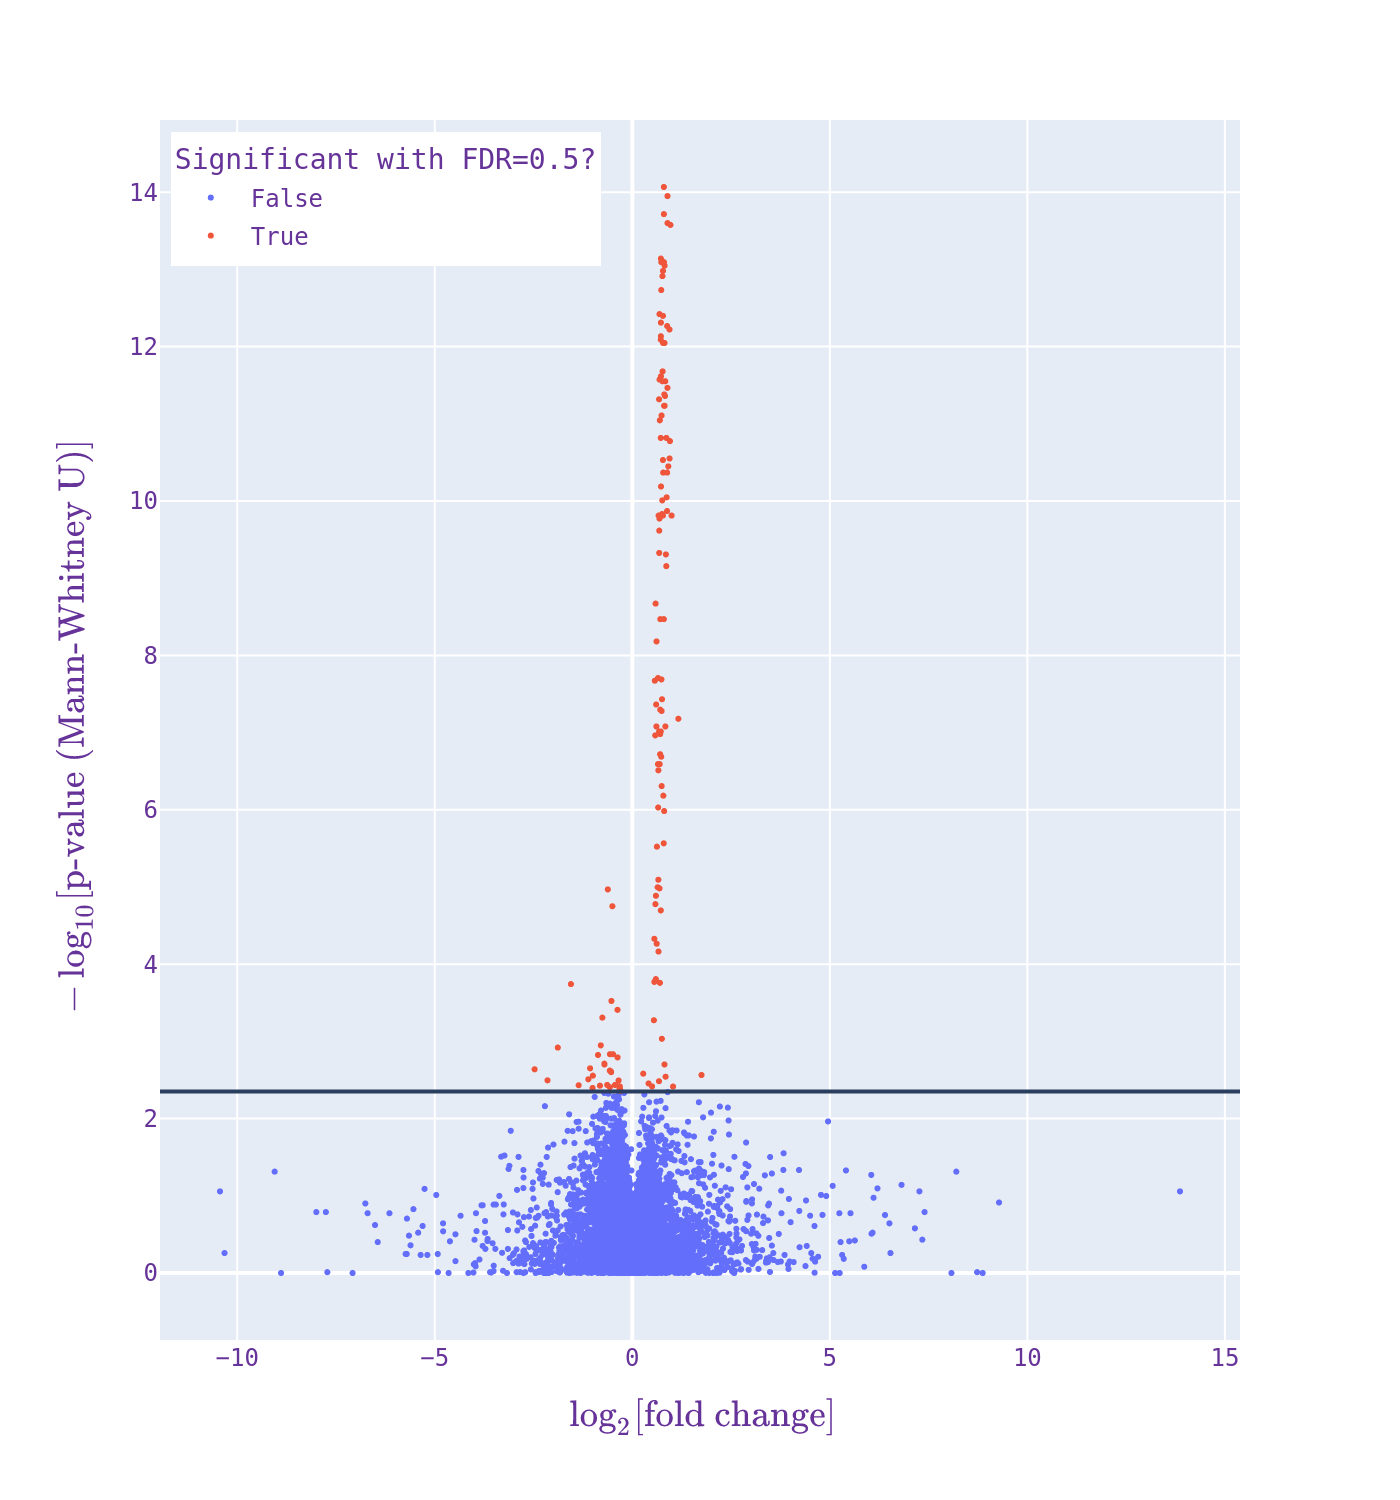

In [20]:
fig.show(renderer="png", scale=2.0)